<a href="https://colab.research.google.com/github/FudgeSato/Quant-Backtesting-Monte-Carlo/blob/main/6_Form_Backtest_Mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta

Enter the stock ticker symbol (e.g., AAPL): AAPL
Choose a trading strategy:
1. Moving Average Crossover
2. RSI Stochastic
3. Fibonacci Retracement
4. Bollinger Bands
5. MACD Crossover
6. ATR-Based Volatility
Enter the number corresponding to your choice: 6


[*********************100%***********************]  1 of 1 completed


Highest Win: 4184.01%
Worst Loss: -74.58%
Average Performance: 282.84%


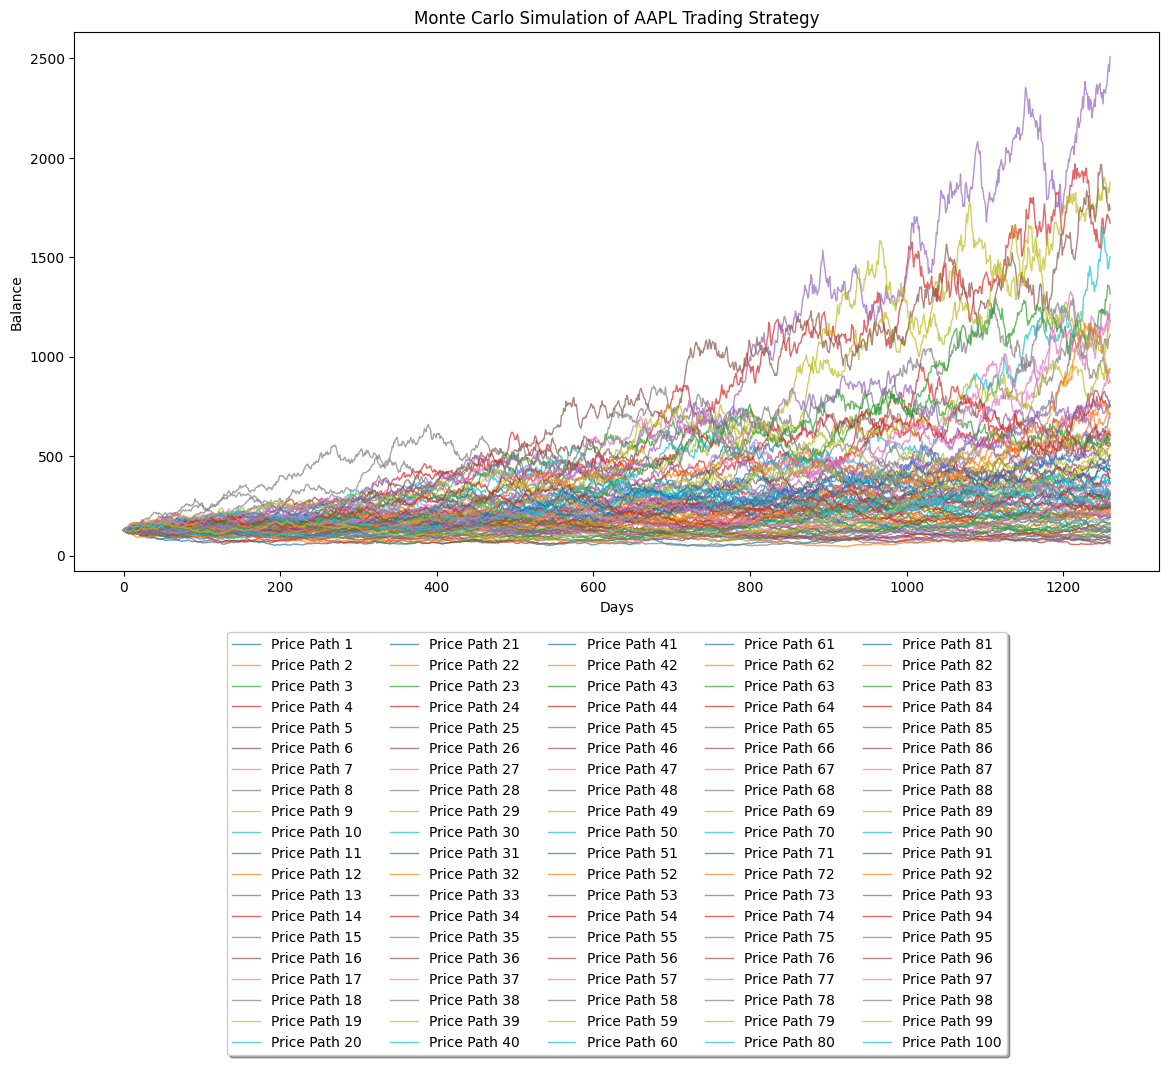

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta

def get_user_input():
    ticker = input("Enter the stock ticker symbol (e.g., AAPL): ").strip().upper()
    print("Choose a trading strategy:")
    print("1. Moving Average Crossover")
    print("2. RSI Stochastic")
    print("3. Fibonacci Retracement")
    print("4. Bollinger Bands")
    print("5. MACD Crossover")
    print("6. ATR-Based Volatility")
    strategy_choice = int(input("Enter the number corresponding to your choice: ").strip())
    return ticker, strategy_choice

def generate_price_path(mean_return, std_return, initial_price, num_days):
    # Generate random returns and calculate cumulative product
    returns = np.random.normal(mean_return, std_return, num_days)
    # Convert initial_price to a scalar value if it's a Series
    initial_price = initial_price.iloc[0] if isinstance(initial_price, pd.Series) else initial_price
    price_path = initial_price * np.cumprod(1 + returns)
    # Insert initial price at the beginning
    price_path = np.insert(price_path, 0, initial_price)

    # Create a DataFrame with 'Close', 'High', and 'Low' columns
    # Assume 'High' and 'Low' are the same as 'Close' for simplicity
    price_path_df = pd.DataFrame(price_path, columns=['Close'])
    price_path_df['High'] = price_path_df['Close']
    price_path_df['Low'] = price_path_df['Close']

    return price_path_df

def generate_simulations(historical_data, num_simulations, num_days):
    returns = historical_data['Close'].pct_change().dropna()
    mean_return = returns.mean()
    std_return = returns.std()
    initial_price = historical_data['Close'].iloc[-1]

    # Create a list to store the simulations (DataFrames)
    simulations = []
    for _ in range(num_simulations):
        price_path_df = generate_price_path(mean_return, std_return, initial_price, num_days)
        simulations.append(price_path_df)  # Append the DataFrame

    return simulations # Return the list of DataFrames

def moving_average_crossover_strategy(price_path):
    short_window = 40
    long_window = 100
    # price_path is expected to be a DataFrame with 'Close' column
    signals = pd.DataFrame(index=price_path.index)  # Use price_path's index
    signals['Close'] = price_path['Close']  # Assign only the 'Close' column
    signals['short_mavg'] = signals['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = signals['Close'].rolling(window=long_window, min_periods=1).mean()
    signals['signal'] = np.where(signals['short_mavg'] > signals['long_mavg'], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()
    return signals

def rsi_stochastic_strategy(price_path):
    rsi_period = 14
    stoch_period = 14
    k_period = 3
    d_period = 3

    price_path = pd.DataFrame(price_path, columns=['Close', 'High', 'Low'])
    price_path['RSI'] = ta.momentum.rsi(price_path['Close'], window=rsi_period)
    price_path['Stoch_K'] = ta.momentum.stoch(price_path['High'], price_path['Low'], price_path['Close'], window=stoch_period, smooth_window=k_period)
    price_path['Stoch_D'] = price_path['Stoch_K'].rolling(window=d_period).mean()

    price_path['signal'] = 0.0
    price_path.loc[(price_path['RSI'] < 30) & (price_path['Stoch_K'] < price_path['Stoch_D']), 'signal'] = 1.0
    price_path.loc[(price_path['RSI'] > 70) & (price_path['Stoch_K'] > price_path['Stoch_D']), 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path


def fibonacci_retracement_strategy(price_path):
    def calculate_fibonacci_levels(price_min, price_max):
        diff = price_max - price_min
        return {
            '61.8%': price_max - 0.618 * diff,
            '50%': price_max - 0.5 * diff,
            '38.2%': price_max - 0.382 * diff
        }

    window = 20
    # Create a range of indices matching the length of price_path
    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    price_path['signal'] = 0.0

    for i in range(window, len(price_path)):
        price_window = price_path['Close'][i-window:i]
        price_min = price_window.min()
        price_max = price_window.max()
        fib_levels = calculate_fibonacci_levels(price_min, price_max)

        current_price = price_path['Close'][i]
        if current_price <= fib_levels['38.2%']:
            price_path.at[price_path.index[i], 'signal'] = 1.0
        elif current_price >= fib_levels['61.8%']:
            price_path.at[price_path.index[i], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def bollinger_bands_strategy(price_path):
    window = 20
    num_std_dev = 2

    # Create a range of indices matching the length of price_path
    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    price_path['SMA'] = price_path['Close'].rolling(window=window).mean()
    price_path['STD'] = price_path['Close'].rolling(window=window).std()
    price_path['Upper_Band'] = price_path['SMA'] + (price_path['STD'] * num_std_dev)
    price_path['Lower_Band'] = price_path['SMA'] - (price_path['STD'] * num_std_dev)

    price_path['signal'] = 0.0
    price_path.loc[price_path['Close'] < price_path['Lower_Band'], 'signal'] = 1.0
    price_path.loc[price_path['Close'] > price_path['Upper_Band'], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def macd_crossover_strategy(price_path):
    short_ema_window = 12
    long_ema_window = 26
    signal_window = 9

    # Create a range of indices matching the length of price_path
    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    price_path['EMA_Short'] = price_path['Close'].ewm(span=short_ema_window, adjust=False).mean()
    price_path['EMA_Long'] = price_path['Close'].ewm(span=long_ema_window, adjust=False).mean()
    price_path['MACD'] = price_path['EMA_Short'] - price_path['EMA_Long']
    price_path['Signal_Line'] = price_path['MACD'].ewm(span=signal_window, adjust=False).mean()

    price_path['signal'] = 0.0
    price_path.loc[price_path['MACD'] > price_path['Signal_Line'], 'signal'] = 1.0
    price_path.loc[price_path['MACD'] < price_path['Signal_Line'], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def atr_volatility_strategy(price_path):
    atr_period = 14
    multiplier = 2

    # Assuming price_path contains 'High' and 'Low' columns for ATR calculation.
    # If not, you'll need to adjust the columns accordingly.
    # price_path should be a DataFrame with 'Close', 'High', 'Low' columns
    # For simulation purposes, if 'High' and 'Low' are not available, consider using 'Close' as a proxy.

    # Create a range of indices matching the length of price_path
    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    # If 'High' and 'Low' are available, use them for ATR calculation
    # price_path['High'] = ... # Assign your high values
    # price_path['Low'] = ...  # Assign your low values
    # price_path['ATR'] = ta.volatility.average_true_range(price_path['High'], price_path['Low'], price_path['Close'], window=atr_period)

    # If 'High' and 'Low' are not available, use 'Close' as a proxy for ATR calculation
    price_path['High'] = price_path['Close']  # Using 'Close' as a proxy for 'High'
    price_path['Low'] = price_path['Close']   # Using 'Close' as a proxy for 'Low'
    price_path['ATR'] = ta.volatility.average_true_range(price_path['High'], price_path['Low'], price_path['Close'], window=atr_period)


    price_path['Upper_Band'] = price_path['Close'] + (price_path['ATR'] * multiplier)
    price_path['Lower_Band'] = price_path['Close'] - (price_path['ATR'] * multiplier)

    price_path['signal'] = 0.0
    price_path.loc[price_path['Close'] < price_path['Lower_Band'], 'signal'] = 1.0
    price_path.loc[price_path['Close'] > price_path['Upper_Band'], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def main():
    ticker, strategy_choice = get_user_input()

    # Gather historical data using yfinance
    spy_data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

    # Set up the simulation framework
    num_simulations = 1000
    num_days = 252 * 5  # One year of trading days

    # Generate simulations
    simulations = generate_simulations(spy_data, num_simulations, num_days)

    # Choose the strategy function based on user input
    strategy_functions = {
        1: moving_average_crossover_strategy,
        2: rsi_stochastic_strategy,
        3: fibonacci_retracement_strategy,
        4: bollinger_bands_strategy,
        5: macd_crossover_strategy,
        6: atr_volatility_strategy
    }

    strategy_function = strategy_functions.get(strategy_choice)
    if strategy_function is None:
        print("Invalid strategy choice.")
        return

    # Apply trading strategy to simulations
    results = [strategy_function(sim) for sim in simulations]

    performance = []
    for result in results:
        initial_price = result['Close'].iloc[0]
        final_price = result['Close'].iloc[-1]
        performance.append((final_price - initial_price) / initial_price * 100)

    highest_win = np.max(performance)
    worst_loss = np.min(performance)
    average_performance = np.mean(performance)

    print(f"Highest Win: {highest_win:.2f}%")
    print(f"Worst Loss: {worst_loss:.2f}%")
    print(f"Average Performance: {average_performance:.2f}%")

    # Plot the first few simulated price paths along with moving averages
    plt.figure(figsize=(14, 7))
    for i in range(100):
        plt.plot(results[i].index, results[i]['Close'], label=f'Price Path {i+1}', alpha=0.7, linewidth=1)

    plt.title(f'Monte Carlo Simulation of {ticker} Trading Strategy')
    plt.xlabel('Days')
    plt.ylabel('Balance')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
    plt.show()

if __name__ == "__main__":
    main()